In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
base_dir = "C:/Users/dell/Documents/VIT/6th_Semester/Medical_Image_Analysis_CSE3042/Project/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

In [4]:
from distutils.dir_util import copy_tree, remove_tree
if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [5]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
#image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=3200, shuffle=False)

Found 6400 images belonging to 4 classes.


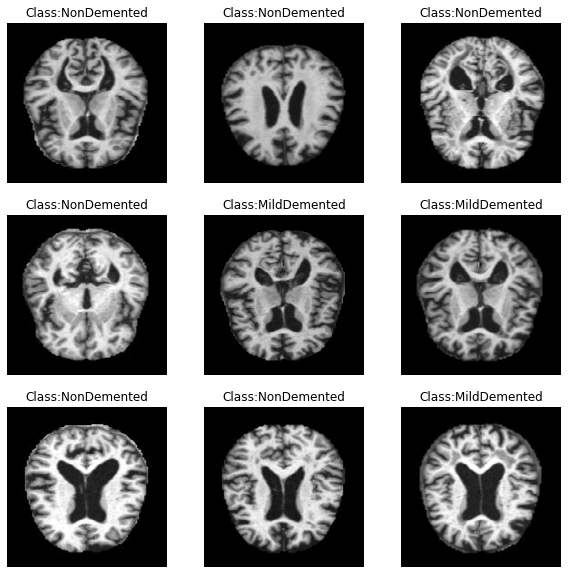

In [7]:
import random as rd
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = rd.randint(0, 3100)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [8]:
# import cv2
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# attempts = 10


In [9]:
import subprocess
import re 

i=0
for cls in CLASSES:
    result = subprocess.run(['ls', train_dir+cls], stdout=subprocess.PIPE)
    res=result.stdout.decode('utf-8')
    res=re.sub(r'\n', ' ', res)
    file_list=res.split(' ')
    j=0
    for x in range(0, 3):
        # (nrows, ncols, index out of entire array of images)
        ax=plt.subplot(4,3,(3*i)+j+1)
        img=plt.imread(train_dir+cls+'/'+file_list[i])
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        j+=1
    i+=1

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [10]:
#Retrieving the data from the ImageDataGenerator iterator
train_data, train_labels = train_data_gen.next()

In [11]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [12]:
print(train_data.shape, train_labels.shape)

(3200, 176, 176, 3) (3200, 4)


In [71]:
#Performing over-sampling of the data, since the classes are imbalanced
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE)
print(train_data.shape, train_labels.shape)

(13440, 176, 176) (4480,)


In [72]:
train_data[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.96470594, 0.96470594, 0.98823535, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.95294124, 0.95294124,
        0.96470594]], dtype=float32)

In [74]:
frame_normed = 255 * (train_data[0] - train_data[0].min()) / (train_data[0].max() - train_data[0].min())
frame_normed = np.array(frame_normed, np.int)

C:\Users\dell\AppData\Local\Temp\ipykernel_20300\334669447.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame_normed = np.array(frame_normed, np.int)


In [76]:
import cv2
gray_img=cv2.equalizeHist(frame_normed)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'cv::equalizeHist'


In [15]:
len(train_data)

4480

In [16]:
new_train_data = []
for i in range(len(train_data)):
    img = train_data[i]
    # gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    frame_normed = 255 * (img - img.min()) / (img.max() - img.min())
    frame_normed = np.array(frame_normed, np.int)
    new_train_data.append(frame_normed)
    print("normalised", frame_normed)
    print("train", new_train_data[i])
    break
    # train_data[i] = gray_img_eqhist

normalised [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
train [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


C:\Users\dell\AppData\Local\Temp\ipykernel_20300\1709036409.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame_normed = np.array(frame_normed, np.int)


In [21]:
from PIL import Image as im
for i in range(len(new_train_data)):
    img = new_train_data[i]
    print(new_train_data[i])
    # img = np.reshape(img, (1024, 720))
    # data = im.fromarray(img)
    gray_img_eqhist = cv2.equalizeHist(img)
    break
    # train_data[i] = gray_img_eqhist

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'cv::equalizeHist'


##### rough 

In [ ]:
type(train_data[0])

numpy.ndarray

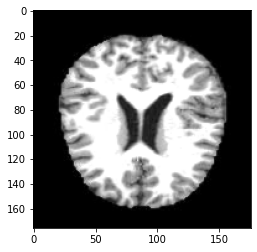

In [ ]:
plt.imshow(train_data[0])

In [ ]:
import cv2

In [ ]:
train_data[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
gray_img=cv2.cvtColor(train_data[0],cv2.COLOR_BGR2GRAY)

In [ ]:
gray_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
type(gray_img)

numpy.ndarray

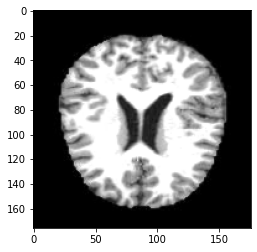

In [ ]:
plt.imshow(train_data[0], cmap='gray')

In [22]:
frame_normed = 255 * (train_data[0] - train_data.min()) / (train_data[0].max() - train_data[0].min())
frame_normed = np.array(frame_normed, np.int)

C:\Users\dell\AppData\Local\Temp\ipykernel_20300\3272814305.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame_normed = np.array(frame_normed, np.int)


In [24]:
frame_normed.shape

(176, 176, 3)

In [29]:
frame_normed

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [30]:
# gray_img=cv2.cvtColor(train_data[0],cv2.COLOR_BGR2GRAY)
img = cv2.equalizeHist(frame_normed)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'cv::equalizeHist'


In [ ]:
cv2.imwrite("img.png", frame_normed)

True

In [ ]:
train_labels

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [ ]:
np.unique(train_labels)

array([0, 1])

In [ ]:
for image in train_data:
    frame_normed = 255 * (image - image.min()) / (image.max() - image.min())
    frame_normed = np.array(frame_normed, np.int)
    cv2.imwrite("img.png", frame_normed)

In [37]:
from os import listdir
 
# get the path/directory
folder_dir = "C:/Users/dell/Documents/VIT/6th_Semester/Medical_Image_Analysis_CSE3042/Project/Alzheimer_s_Dataset/train/MildDemented"
for images in os.listdir(folder_dir):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
        # frame_normed = 255 * (image - image.min()) / (image.max() - image.min())
        # frame_normed = np.array(frame_normed, np.int)
        print(folder_dir + "/" + images)
        img = cv2.imread(folder_dir + "/" + images)
        gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        print(gray_img)
        gray_img_eqhist = cv2.equalizeHist(gray_img)
        cv2.imwrite("img.png", gray_img_eqhist)
        break

C:/Users/dell/Documents/VIT/6th_Semester/Medical_Image_Analysis_CSE3042/Project/Alzheimer_s_Dataset/train/MildDemented/mildDem0.jpg
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [89]:
arr = np.array([[1,2,3],[2,3]])
print(arr.shape)


(2,)


C:\Users\dell\AppData\Local\Temp\ipykernel_20300\4024088991.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array([[1,2,3],[2,3]])


In [100]:
np.reshape(arr,5)
print(arr.shape)
print(arr)

ValueError: cannot reshape array of size 2 into shape (5,)